In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import files
files.upload()

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d dmitrybabko/speech-emotion-recognition-en

100% 983M/987M [00:26<00:00, 42.0MB/s]
100% 987M/987M [00:26<00:00, 39.6MB/s]


In [ ]:
!unzip speech-emotion-recognition-en.zip

In [ ]:
save_path = "/content/drive/MyDrive/Colab Notebooks/Pattern/projects/Assignment3/"
Crema   = "/content/drive/MyDrive/Colab Notebooks/Pattern/projects/Assignment3/data/Crema"
EMOTIONS_DICT_CREMA = {'SAD' :'sad', 'ANG' :'angry', 'DIS' :'disgust', 'FEA' :'fear', 'HAP' :'happy', 'NEU' :'neutral'}
COLUMNS_NAMES = ['Path', 'Emotion']

In [ ]:
import os

import pandas as pd
import numpy as np
import random
import pickle
import gc

import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Audio

import tensorflow as tf
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.optimizers import Adam

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

## Loading Data:

#### Crema data:

In [ ]:
crema_emp_waves = os.listdir(Crema)
crema_wav_emotions = []
for wav_file in crema_emp_waves:
    path = Crema + '/' + wav_file
    emotion = wav_file.split('.')[0].split('_')[2]
    crema_wav_emotions.append([path, emotion])

In [ ]:
crema_df = pd.DataFrame(crema_wav_emotions, columns=COLUMNS_NAMES)
crema_df['Emotion'].replace(EMOTIONS_DICT_CREMA, inplace=True)

crema_df.head()

,Path,Emotion
0,/content/drive/MyDrive/Colab Notebooks/Pattern...,neutral
1,/content/drive/MyDrive/Colab Notebooks/Pattern...,neutral
2,/content/drive/MyDrive/Colab Notebooks/Pattern...,fear
3,/content/drive/MyDrive/Colab Notebooks/Pattern...,fear
4,/content/drive/MyDrive/Colab Notebooks/Pattern...,disgust


In [ ]:
crema_df['Emotion'].value_counts()

fear       1271
disgust    1271
sad        1271
angry      1271
happy      1271
neutral    1087
Name: Emotion, dtype: int64

(7442, 2)


<Axes: >

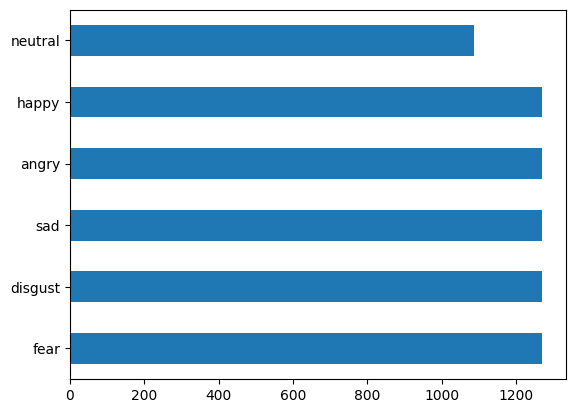

In [ ]:
print(crema_df.shape)
crema_df['Emotion'].value_counts().plot(kind='barh')

## Data Information:

In [ ]:
def waveform(data, sampling_rate, emotion):
    plt.figure(figsize=(10, 3))
    plt.title(emotion+' - Waveform')
    librosa.display.waveshow(data, sr=sampling_rate)
    plt.show()

def spectrum(data, sampling_rate, emotion):
    plt.figure(figsize=(10, 3))
    plt.title(emotion+' - Spectrum')
    plt.magnitude_spectrum(data,Fs=sampling_rate)
    plt.show()

def spectrogram(data, sampling_rate, emotion):
    plt.figure(figsize=(10, 3))
    # converts the data into short term fourier transform
    short_term_ft = librosa.stft(data)
    db = librosa.amplitude_to_db(abs(short_term_ft))
    plt.title(emotion+' - Spectrogram')
    librosa.display.specshow(db, sr=sampling_rate)#, x_axis='time', y_axis='hz')   
    plt.colorbar()

def wav_info(emotion):
    sample = crema_df[crema_df['Emotion'] == emotion]
    sample_index = random.randint(0, sample.shape[0])
    sample = sample['Path'].iloc[sample_index]
    
    print(sample)
    print("sample index:",sample_index)

    data, sampling_rate = librosa.load(sample)
    waveform(data, sampling_rate, emotion)
    spectrum(data, sampling_rate, emotion)
    spectrogram(data, sampling_rate, emotion)
    return sample

/content/drive/MyDrive/Colab Notebooks/Pattern/projects/Assignment3/data/Crema/1072_TSI_SAD_XX.wav
sample index: 228


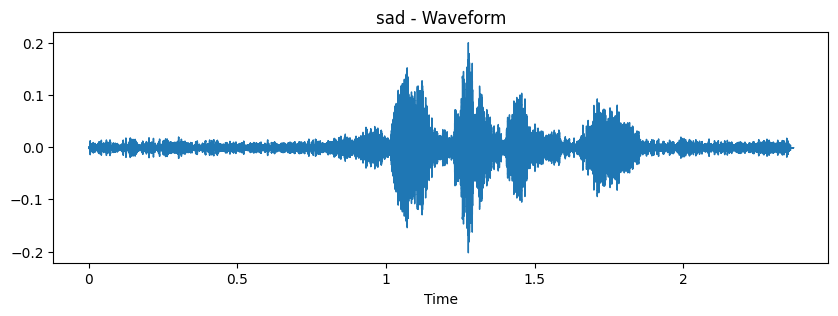

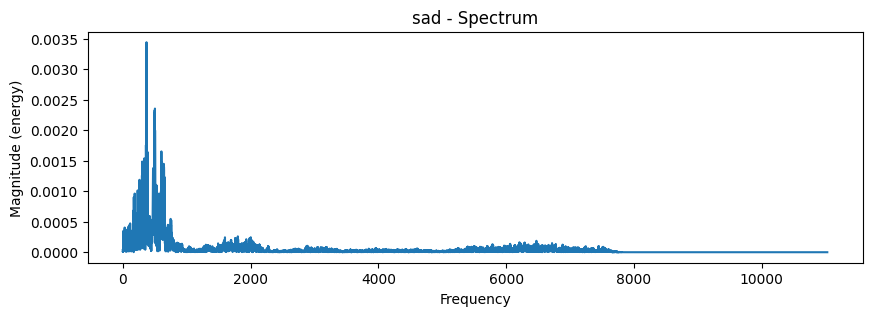

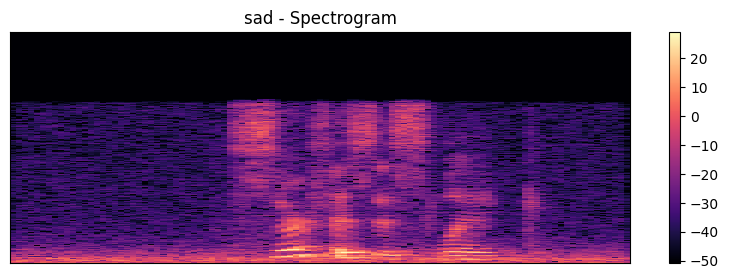

In [ ]:
sample = wav_info('sad')
Audio(sample)

/content/drive/MyDrive/Colab Notebooks/Pattern/projects/Assignment3/data/Crema/1083_IEO_HAP_LO.wav
sample index: 51


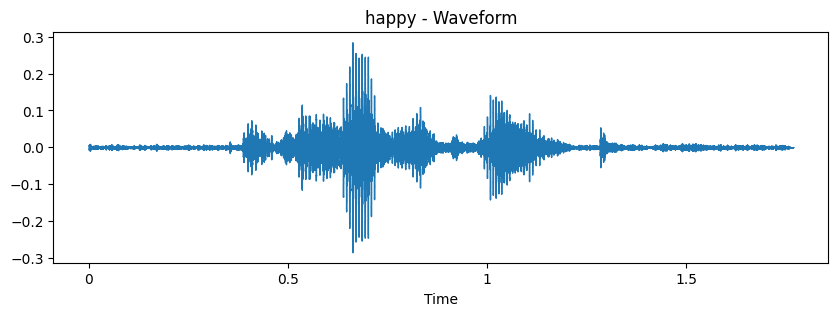

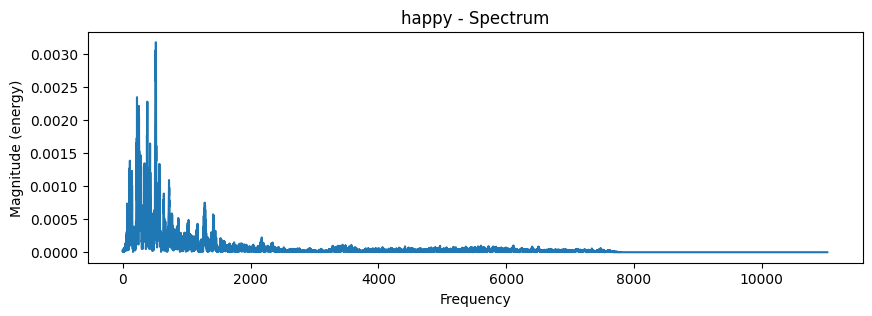

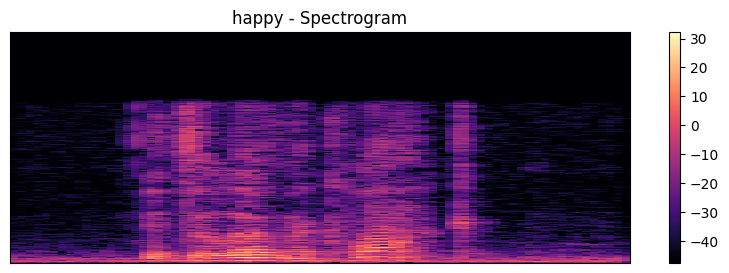

In [ ]:
sample = wav_info('happy')
Audio(sample)

/content/drive/MyDrive/Colab Notebooks/Pattern/projects/Assignment3/data/Crema/1044_ITS_ANG_XX.wav
sample index: 563


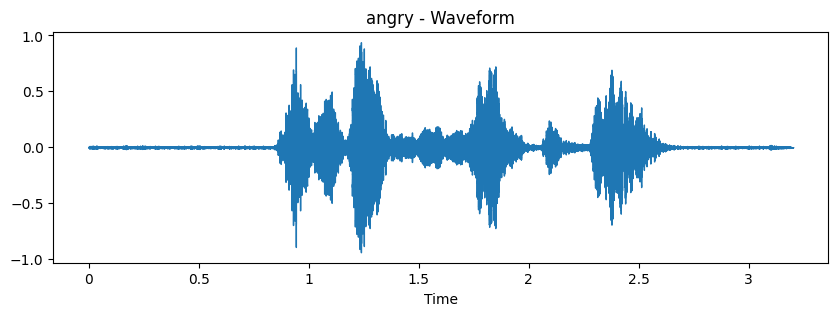

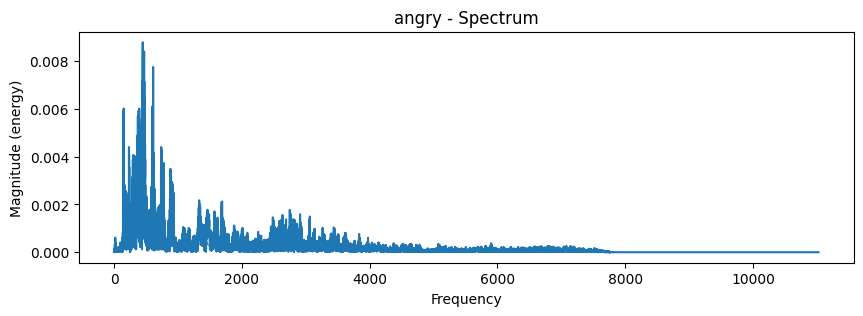

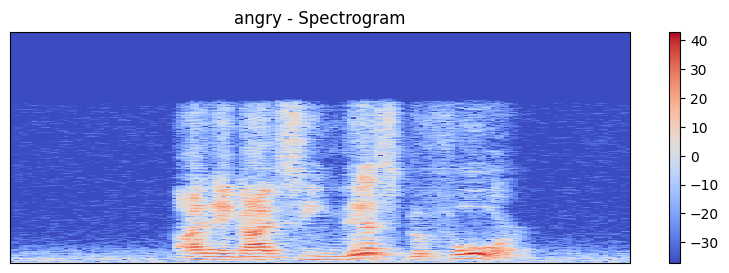

In [ ]:
sample = wav_info('angry')
Audio(sample)

/content/drive/MyDrive/Colab Notebooks/Pattern/projects/Assignment3/data/Crema/1068_IEO_FEA_LO.wav
sample index: 501


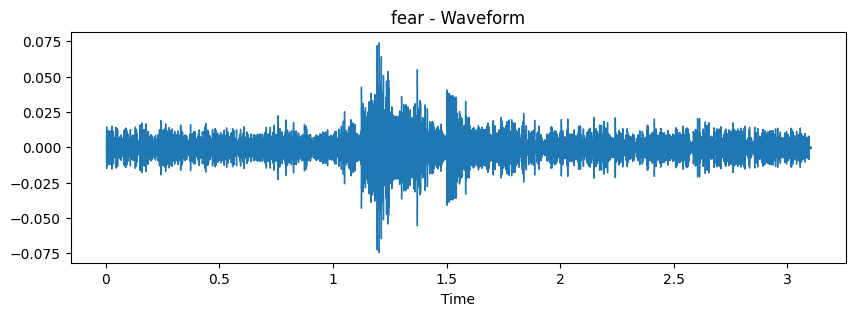

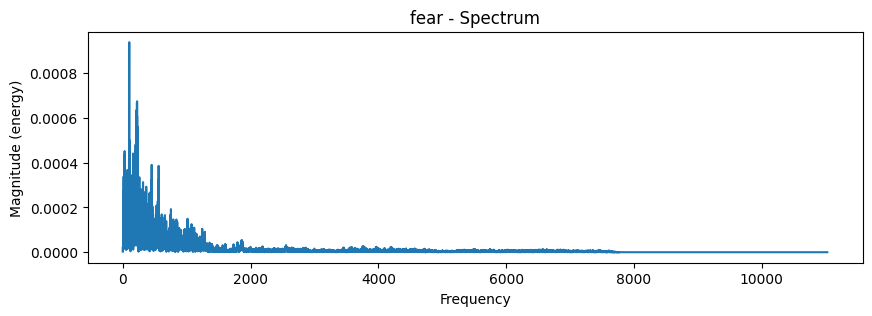

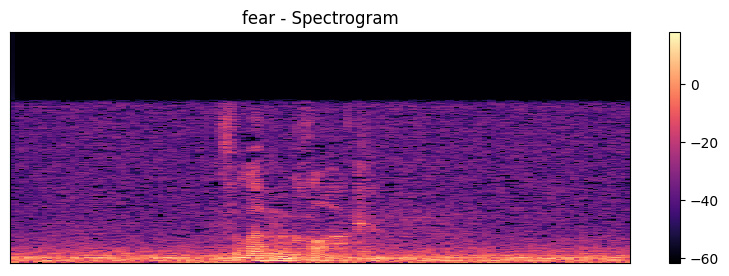

In [ ]:
sample = wav_info('fear')
Audio(sample)

/content/drive/MyDrive/Colab Notebooks/Pattern/projects/Assignment3/data/Crema/1062_DFA_DIS_XX.wav
sample index: 457


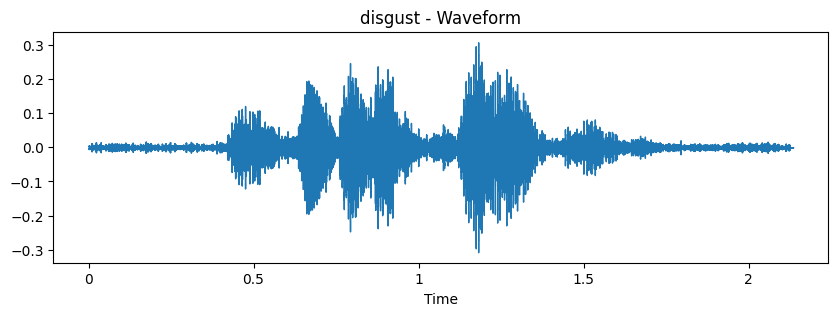

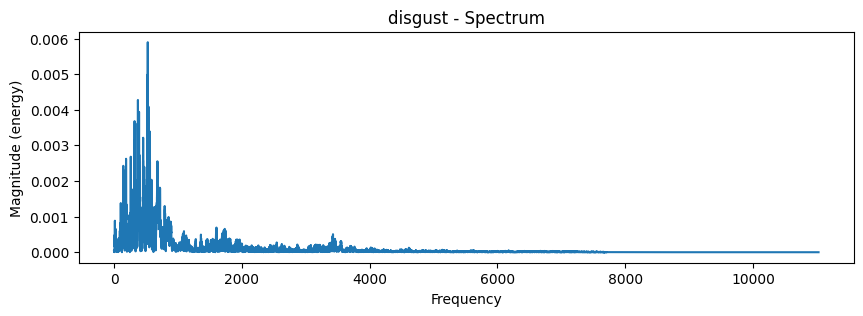

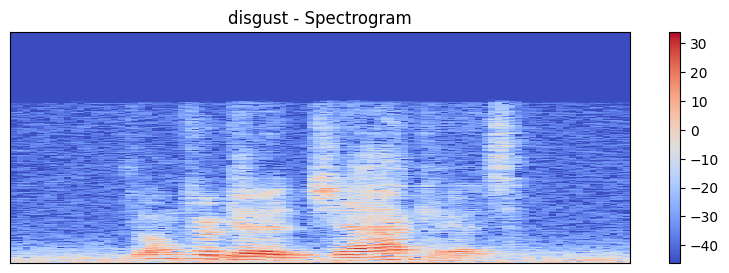

In [ ]:
sample = wav_info('disgust')
Audio(sample)

/content/drive/MyDrive/Colab Notebooks/Pattern/projects/Assignment3/data/Crema/1080_ITS_NEU_XX.wav
sample index: 285


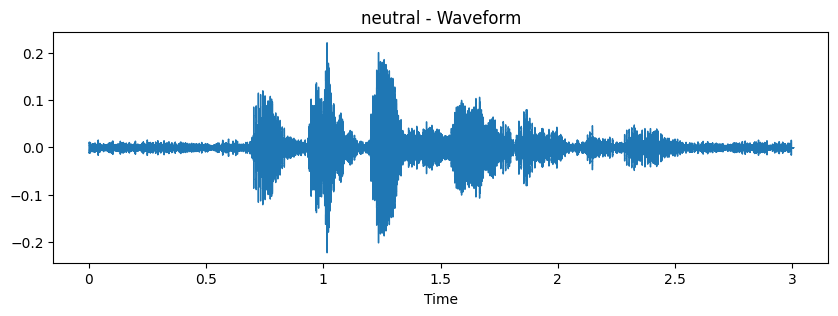

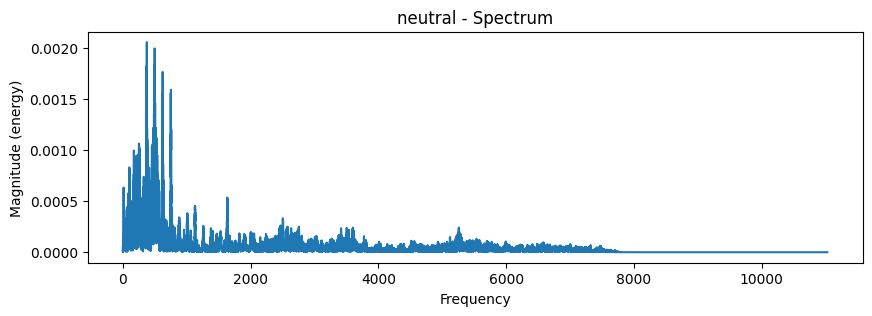

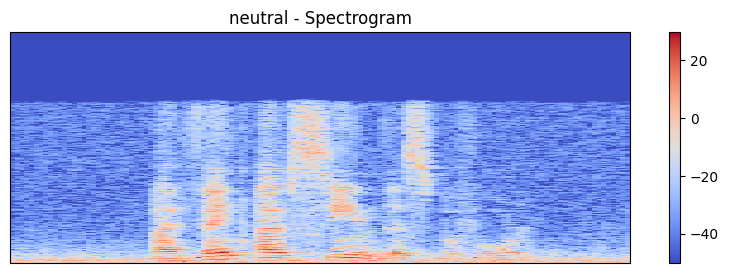

In [ ]:
sample = wav_info('neutral')
Audio(sample)

## Data pre-processing:

#### Data Augmentaions:

In [ ]:
def add_noise(audio, noise_factor=0.01):
    np.random.seed(42)
    noise = np.random.randn(len(audio))
    augmented_audio = audio + noise_factor * noise
    return augmented_audio


def pitch_shift(audio, sample_rate, n_steps=5):
    return librosa.effects.pitch_shift(audio, sr=sample_rate, n_steps=n_steps)


def time_stretch(audio, length, factor=0.9):
    result = librosa.effects.time_stretch(audio, rate=1/factor)
    if len(result) != length:
        pad_size = length - len(result)
        result = np.pad(result, (0, pad_size), mode='constant')
    return result

def extend_data(audio, sample_rate):
    audio_noise = add_noise(audio)
    audio_pitch = pitch_shift(audio, sample_rate)
    audio_shift = time_stretch(audio, len(audio))

    # audio_noise_pitch = pitch_shift(audio_noise, sample_rate)
    # audio_noise_shift = time_stretch(audio_noise, len(audio))
    # audio_noise_pitch_shift = time_stretch(audio_noise_pitch, len(audio))

    return [
        audio
        ,audio_noise
        # ,audio_pitch
        # ,audio_shift
        # ,audio_noise_pitch
        # ,audio_noise_shift
        # ,audio_noise_pitch_shift
    ]

#### Features Extraction:

In [ ]:
train_val_data, test_data, train_val_labels, test_labels = train_test_split(crema_df['Path'], crema_df['Emotion'], test_size=0.3, stratify=crema_df['Emotion'])

In [ ]:
train_val_data.shape, train_val_labels.shape, test_data.shape, test_labels.shape

((5209,), (5209,), (2233,), (2233,))

In [ ]:
FRAME_LENGTH = 2048
HOP_LENGTH = 512


# 1-zero-crossing rate
def zero_crossing_rate(audio):
    """
    The zero-crossing rate measures the number of times a signal crosses the zero axis and can provide insights into the temporal characteristics of the audio.
    """
    zcr = librosa.feature.zero_crossing_rate(y=audio, frame_length=FRAME_LENGTH, hop_length=HOP_LENGTH)
    return np.mean(zcr.T, axis=0)


# 2-Energy
def energy(audio):
    """
    Energy represents the overall power or loudness of an audio signal and can be calculated by summing the squared values of the audio samples.    
    """
    energy_rms = librosa.feature.rms(y=audio, frame_length=FRAME_LENGTH, hop_length=HOP_LENGTH)
    return np.mean(energy_rms.T, axis=0)


# 3-Mel-frequency Cepstral
def mfcc(audio, sample_rate):
    """
    Mel-frequency Cepstral Coefficients (MFCC) represent the spectral characteristics of an audio signal.
    """
    mfcc = librosa.feature.mfcc(y=audio, sr=sample_rate, n_fft=FRAME_LENGTH, hop_length=HOP_LENGTH)
    return np.mean(mfcc.T, axis=0)


# 4-chroma
def chroma(audio, sample_rate):
    """
    Chroma features capture the pitch and harmonic content of an audio signal.
    """
    chroma = librosa.feature.chroma_stft(y=audio, sr=sample_rate, n_fft=FRAME_LENGTH, hop_length=HOP_LENGTH)
    return np.mean(chroma.T, axis=0)


# 5-contrast
def contrast(audio, sample_rate):
    """
    Spectral contrast measures the difference in amplitude between peaks and valleys in the frequency spectrum, providing information about the spectral texture of the audio.
    """
    contrast = librosa.feature.spectral_contrast(y=audio, sr=sample_rate, n_fft=FRAME_LENGTH, hop_length=HOP_LENGTH)
    return np.mean(contrast.T, axis=0)


# 6.1-mel spectrogram 1D
def mel_spectrogram1D(audio, sample_rate):
    mel_spec = librosa.feature.melspectrogram(y=audio, sr=sample_rate, n_fft=FRAME_LENGTH, hop_length=HOP_LENGTH)
    return np.mean(mel_spec.T, axis=0)


# 6.2-mel spectrogram 2D
def mel_spectrogram2D(audio, sample_rate):
    mel_spec = librosa.feature.melspectrogram(y=audio, sr=sample_rate, n_fft=FRAME_LENGTH, hop_length=HOP_LENGTH)
    return mel_spec

def extract_features(audio, sample_rate):
    features = np.concatenate((
        zero_crossing_rate(audio), 
        energy(audio), 
        mfcc(audio, sample_rate),
        chroma(audio, sample_rate),
        contrast(audio, sample_rate),
        mel_spectrogram1D(audio, sample_rate)
        ), axis=None)
    return features

In [ ]:
def padding(data_train, data_test):
  padd_data_train = []
  padd_data_test = []

  max_shape = max( max([s.shape for s in data_train])[1], max([s.shape for s in data_test])[1])

  for features in data_train:
    if features.shape[1] < max_shape:
        size = max_shape - features.shape[1]
        padd_data_train.append(np.pad(features, ((0, 0), (0, size)), mode='constant'))
    else:
        padd_data_train.append(features)

  for features in data_test:
    if features.shape[1] < max_shape:
        size = max_shape - features.shape[1]
        padd_data_test.append(np.pad(features, ((0, 0), (0, size)), mode='constant'))
    else:
        padd_data_test.append(features)

  return np.array(padd_data_train), np.array(padd_data_test)

In [ ]:
# train_val_data, test_data
train_feature_space1_data = []
train_feature_space2_data = []

test_feature_space1_data = []
test_feature_space2_data = []


for i in range(train_val_data.shape[0]):
    data_train_path = train_val_data.iloc[i]
    train_audio, train_sample_rate = librosa.load(data_train_path)
    
    extended_data = extend_data(train_audio, train_sample_rate)
    for data in extended_data:
        train_feature_space1_data.append(extract_features(data, train_sample_rate))
        train_feature_space2_data.append(mel_spectrogram2D(data, train_sample_rate))


for i in range(test_data.shape[0]):
    data_test_path = test_data.iloc[i]
    test_audio, test_sample_rate = librosa.load(data_test_path)
    test_feature_space1_data.append(extract_features(test_audio, test_sample_rate))
    test_feature_space2_data.append(mel_spectrogram2D(test_audio, test_sample_rate))

/usr/local/lib/python3.10/dist-packages/librosa/core/pitch.py:102: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


In [ ]:

# saving the lists

with open(save_path+'train_feature_space1_data.pkl', 'wb') as file:
    pickle.dump(train_feature_space1_data, file)

with open(save_path+'train_feature_space2_data.pkl', 'wb') as file:
    pickle.dump(train_feature_space2_data, file)

with open(save_path+'test_feature_space1_data.pkl', 'wb') as file:
    pickle.dump(test_feature_space1_data, file)

with open(save_path+'test_feature_space2_data.pkl', 'wb') as file:
    pickle.dump(test_feature_space2_data, file)



# labels
with open(save_path+'train_val_labels.pkl', 'wb') as file:
    pickle.dump(train_val_labels, file)

with open(save_path+'test_labels.pkl', 'wb') as file:
    pickle.dump(test_labels, file)

In [ ]:
# loading the lists


with open(save_path+'train_feature_space1_data.pkl', 'rb') as file:
    train_feature_space1_data = pickle.load(file)

with open(save_path+'train_feature_space2_data.pkl', 'rb') as file:
    train_feature_space2_data = pickle.load(file)

with open(save_path+'test_feature_space1_data.pkl', 'rb') as file:
    test_feature_space1_data = pickle.load(file)

with open(save_path+'test_feature_space2_data.pkl', 'rb') as file:
    test_feature_space2_data = pickle.load(file)

# labels
with open(save_path+'train_val_labels.pkl', 'rb') as file:
    train_val_labels = pickle.load(file)

with open(save_path+'test_labels.pkl', 'rb') as file:
    test_labels = pickle.load(file)

In [ ]:
train_feature_space1_data = np.array(train_feature_space1_data)
test_feature_space1_data = np.array(test_feature_space1_data)

train_feature_space2_data, test_feature_space2_data = padding(train_feature_space2_data, test_feature_space2_data)

In [ ]:
train_feature_space1_data.shape, train_feature_space2_data.shape, test_feature_space1_data.shape, test_feature_space2_data.shape

((10418, 169), (10418, 128, 216), (2233, 169), (2233, 128, 216))

**Loading Features:**

In [ ]:
train_val_labels = np.repeat(np.array(train_val_labels), 2)

In [ ]:
train_val_labels = pd.DataFrame(train_val_labels)
train_val_labels = train_val_labels.rename(columns={0: 'Emotion'})

test_labels = pd.DataFrame(test_labels)

In [ ]:
train_val_labels.shape, test_labels.shape

((10418, 1), (2233, 1))

In [ ]:
# Encoding:
train_val_labels_row = train_val_labels.shape[0]
all_labels = pd.concat([train_val_labels, test_labels])
encoder = OneHotEncoder()
all_labels_enc = pd.DataFrame(encoder.fit_transform(np.array(all_labels).reshape(-1,1)).toarray())
labels_train_enc = all_labels_enc.iloc[:train_val_labels_row,:]
labels_test_enc = all_labels_enc.iloc[train_val_labels_row:,:]

del all_labels
del all_labels_enc
del train_val_labels
del test_labels
gc.collect()

52

In [ ]:
labels_train_enc.shape, labels_test_enc.shape

((10418, 6), (2233, 6))

In [ ]:
data_train_s1, data_val_s1, labels_train_s1, labels_val_s1 = train_test_split(train_feature_space1_data, labels_train_enc, test_size=0.05, stratify=labels_train_enc)
data_train_s2, data_val_s2, labels_train_s2, labels_val_s2 = train_test_split(train_feature_space2_data, labels_train_enc, test_size=0.05, stratify=labels_train_enc)
del train_feature_space1_data
del train_feature_space2_data
gc.collect()

0

In [ ]:
pd.DataFrame(data_train_s1).head()

,0,1,2,3,4,5,6,7,8,9,...,159,160,161,162,163,164,165,166,167,168
0,0.365549,0.014745,-229.446442,20.603234,18.334794,14.187043,10.084309,6.882652,3.864041,1.887579,...,7.347059e-03,6.882412e-03,7.339969e-03,7.028278e-03,6.941523e-03,7.173238e-03,7.120158e-03,6.974565e-03,6.791689e-03,7.125942e-03
1,0.039338,0.014352,-421.377197,142.295410,21.619734,52.459305,-12.169572,13.550567,-11.616696,6.318855,...,2.483735e-08,2.250979e-08,2.086634e-08,1.970237e-08,1.883643e-08,1.819205e-08,1.772944e-08,1.739353e-08,1.717664e-08,1.704208e-08
2,0.042767,0.023684,-388.339630,149.422394,7.583996,38.808174,-11.584514,15.628503,-5.287646,6.129835,...,2.603933e-09,2.396137e-09,2.248248e-09,2.143837e-09,2.066303e-09,2.008942e-09,1.968387e-09,1.939160e-09,1.920811e-09,1.909280e-09
3,0.105522,0.076778,-292.421051,77.833817,6.905009,39.701065,-4.949998,18.182198,-16.286167,2.745688,...,4.142823e-09,3.728145e-09,3.441861e-09,3.241608e-09,3.093877e-09,2.984507e-09,2.906172e-09,2.849431e-09,2.812971e-09,2.790160e-09
4,0.380538,0.014231,-228.945689,20.455947,17.437540,12.297789,7.296403,3.852893,-0.086378,-1.775309,...,7.270584e-03,6.800980e-03,7.467330e-03,7.215647e-03,7.050112e-03,7.302358e-03,7.371144e-03,6.966969e-03,6.717332e-03,7.062003e-03


In [ ]:
scaler_1d = StandardScaler()
data_train_s1 = scaler_1d.fit_transform(np.array(data_train_s1))
data_test_s1 = scaler_1d.transform(np.array(test_feature_space1_data))
data_val_s1 = scaler_1d.transform(np.array(data_val_s1))

In [ ]:
scaler_2d = StandardScaler()
data_train_s2 = scaler_2d.fit_transform(np.array(data_train_s2))
data_test_s2 = scaler_2d.transform(np.array(test_feature_space2_data))
data_val_s2 = scaler_2d.transform(np.array(data_val_s2))

data_test_s1 = test_feature_space1_data
data_test_s2 = test_feature_space2_data

In [ ]:
pd.DataFrame(data_train_s1).head()

In [ ]:
data_train_s1 = np.expand_dims(data_train_s1, axis=2)
data_val_s1 = np.expand_dims(data_val_s1, axis=2)
data_test_s1 = np.expand_dims(data_test_s1, axis=2)

data_train_s2 = np.expand_dims(data_train_s2, axis=3)
data_val_s2 = np.expand_dims(data_val_s2, axis=3)
data_test_s2 = np.expand_dims(data_test_s2, axis=3)

In [ ]:
print("Feature Space 1 data:")
print("train data:  ",data_train_s1.shape)
print("train labels:",labels_train_s1.shape)
print("test data:   ",data_test_s1.shape)
print("test labels: ",labels_test_enc.shape)
print("val data:    ",data_val_s1.shape)
print("val labels:  ",labels_val_s1.shape)

Feature Space 1 data:
train data:   (9897, 169, 1)
train labels: (9897, 6)
test data:    (2233, 169, 1)
test labels:  (2233, 6)
val data:     (521, 169, 1)
val labels:   (521, 6)


In [ ]:
print("Feature Space 2 data:")
print("train data:  ",data_train_s2.shape)
print("train labels:",labels_train_s2.shape)
print("test data:   ",data_test_s2.shape)
print("test labels: ",labels_test_enc.shape)
print("val data:    ",data_val_s2.shape)
print("val labels:  ",labels_val_s2.shape)

Feature Space 2 data:
train data:   (9897, 128, 216, 1)
train labels: (9897, 6)
test data:    (2233, 128, 216, 1)
test labels:  (2233, 6)
val data:     (521, 128, 216, 1)
val labels:   (521, 6)


In [ ]:
import sys
local_vars = list(locals().items())
for var, obj in local_vars:
    print(var, sys.getsizeof(obj))

## CNN:

In [ ]:
epochs_30 = 30

##### Helper funciotns:

In [ ]:
def get_plots(history, epochs=100):
  epochs = [i for i in range(epochs)]
  fig , ax = plt.subplots(1,2)
  train_acc = history.history['accuracy']
  train_loss = history.history['loss']
  Validation_acc = history.history['val_accuracy']
  Validation_loss = history.history['val_loss']

  fig.set_size_inches(15,5)
  ax[0].plot(epochs , train_loss , label = 'Training Loss')
  ax[0].plot(epochs , Validation_loss , label = 'Validation Loss')
  ax[0].set_title('Training & Validation Loss')
  ax[0].legend()
  ax[0].set_xlabel("Epochs")

  ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
  ax[1].plot(epochs , Validation_acc , label = 'Validation Accuracy')
  ax[1].set_title('Training & Validation Accuracy')
  ax[1].legend()
  ax[1].set_xlabel("Epochs")
  plt.show()

In [ ]:
def get_stats(model, data_test, data_labels):
  data_pred = model.predict(data_test)
  pred_labels = encoder.inverse_transform(data_pred)
 
  data_labels = encoder.inverse_transform(data_labels)
  cm = confusion_matrix(data_labels, pred_labels)


  cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
  sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
  plt.title('Confusion Matrix', size=20)
  plt.xlabel('Predicted Labels', size=14)
  plt.ylabel('Actual Labels', size=14)
  plt.show()
  print(classification_report(data_labels, pred_labels))

### 1D-CNN:

#### CNN Architectures:

 ##### AlexNet architecture with 1D convolutional layers

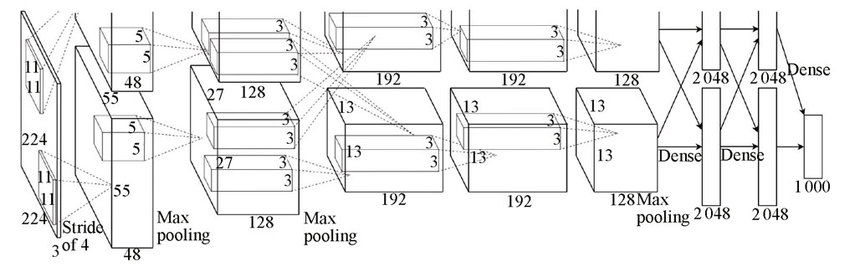

In [ ]:
def alex_net(train_data, train_labels, test_data, test_labels, val_data, val_labels, epochs=100, learning_rate = 0.001):
    # Define the CNN model
    alexnet_model = tf.keras.Sequential()

    # Convolutional layers
    alexnet_model.add(layers.Conv1D(96, kernel_size=11, strides=4, activation='relu', input_shape=(train_data.shape[1], 1)))
    alexnet_model.add(layers.MaxPooling1D(pool_size=3, strides=4))#
    alexnet_model.add(layers.Conv1D(256, kernel_size=5, activation='relu'))
    alexnet_model.add(layers.MaxPooling1D(pool_size=3, strides=4))#
    alexnet_model.add(layers.Conv1D(384, kernel_size=3, activation='relu'))
    alexnet_model.add(layers.Conv1D(384, kernel_size=3, activation='relu'))
    alexnet_model.add(layers.Conv1D(256, kernel_size=3, activation='relu'))
    alexnet_model.add(layers.MaxPooling1D(pool_size=3, padding='same', strides=2))
    # Flatten the feature 
    alexnet_model.add(layers.Flatten())
    # Dense layers
    alexnet_model.add(layers.Dense(4096, activation='relu'))
    alexnet_model.add(layers.Dense(4096, activation='relu'))
    alexnet_model.add(layers.Dense(train_labels.shape[1], activation='softmax')) 

    # Compile the model
    # alexnet_model.compile(optimizer=Adam(learning_rate=learning_rate), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    alexnet_model.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])
    

    # Train the model
    history = alexnet_model.fit(train_data, train_labels, epochs=epochs, validation_data=(val_data, val_labels))

    # Evaluate the model
    test_loss, test_accuracy = alexnet_model.evaluate(test_data, test_labels)
    print("Test Loss:", test_loss)
    print("Test Accuracy:", test_accuracy)

    return {
      "model":alexnet_model
      ,"history":history
      ,"test_accuracy":test_accuracy
      ,"test_loss":test_loss
     }

##### VGG-16:

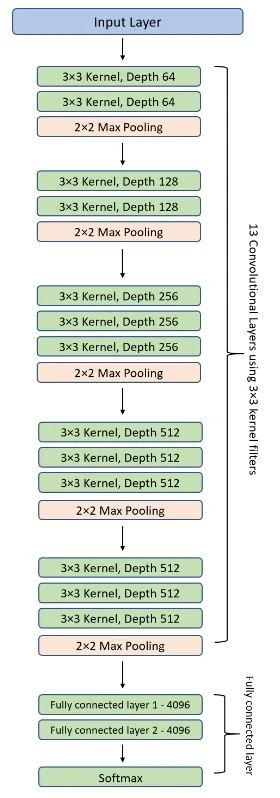

In [ ]:
def vgg16(train_data, train_labels, test_data, test_labels, val_data, val_labels, epochs=100, learning_rate=0.001):

    # Define the VGG16-based CNN model
    vgg16_model = tf.keras.Sequential()

    # Block 1
    vgg16_model.add(layers.Conv1D(64, kernel_size=3, activation='relu', padding='same', input_shape=(train_data.shape[1], 1)))
    vgg16_model.add(layers.Conv1D(64, kernel_size=3, activation='relu', padding='same'))
    vgg16_model.add(layers.MaxPooling1D(pool_size=2, strides=2))

    # Block 2
    vgg16_model.add(layers.Conv1D(128, kernel_size=3, activation='relu', padding='same'))
    vgg16_model.add(layers.Conv1D(128, kernel_size=3, activation='relu', padding='same'))
    vgg16_model.add(layers.MaxPooling1D(pool_size=2, strides=2))

    # Block 3
    vgg16_model.add(layers.Conv1D(256, kernel_size=3, activation='relu', padding='same'))
    vgg16_model.add(layers.Conv1D(256, kernel_size=3, activation='relu', padding='same'))
    vgg16_model.add(layers.Conv1D(256, kernel_size=3, activation='relu', padding='same'))
    vgg16_model.add(layers.MaxPooling1D(pool_size=2, strides=2))

    # Block 4
    vgg16_model.add(layers.Conv1D(512, kernel_size=3, activation='relu', padding='same'))
    vgg16_model.add(layers.Conv1D(512, kernel_size=3, activation='relu', padding='same'))
    vgg16_model.add(layers.Conv1D(512, kernel_size=3, activation='relu', padding='same'))
    vgg16_model.add(layers.MaxPooling1D(pool_size=2, strides=2))

    # Block 5
    vgg16_model.add(layers.Conv1D(512, kernel_size=3, activation='relu', padding='same'))
    vgg16_model.add(layers.Conv1D(512, kernel_size=3, activation='relu', padding='same'))
    vgg16_model.add(layers.Conv1D(512, kernel_size=3, activation='relu', padding='same'))
    vgg16_model.add(layers.MaxPooling1D(pool_size=2, strides=2))

    # Flatten the feature maps
    vgg16_model.add(layers.Flatten())

    # Dense layers
    vgg16_model.add(layers.Dense(4096, activation='relu'))
    vgg16_model.add(layers.Dense(4096, activation='relu'))
    vgg16_model.add(layers.Dense(train_labels.shape[1], activation='softmax'))  # num_classes is the number of classes

    # Compile the model
    vgg16_model.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])
    
    
    # Train the model
    history = vgg16_model.fit(train_data, train_labels, epochs=epochs, validation_data=(val_data, val_labels))

    # Evaluate the model
    test_loss, test_accuracy = vgg16_model.evaluate(test_data, test_labels)
    print("Test Loss:", test_loss)
    print("Test Accuracy:", test_accuracy)

    return {
      "model":vgg16_model
      ,"history":history
      ,"test_accuracy":test_accuracy
      ,"test_loss":test_loss
     }

##### LeNet-5:


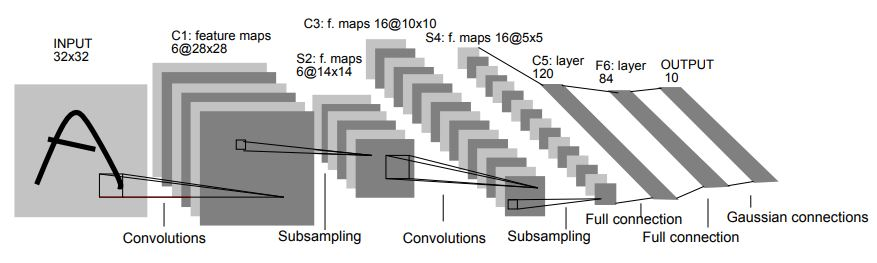

In [ ]:
def leNet5(train_data, train_labels, test_data, test_labels, val_data, val_labels, epochs=100, learning_rate=0.001):

    # Define the LeNet-5 CNN model
    leNet5_model = tf.keras.Sequential()

    # Layer 1: Convolutional layer
    leNet5_model.add(layers.Conv1D(6, kernel_size=5, activation='relu', input_shape=(train_data.shape[1], 1)))
    leNet5_model.add(layers.MaxPooling1D(pool_size=2, strides=2))

    # Layer 2 Convolutional layer
    leNet5_model.add(layers.Conv1D(16, kernel_size=5, activation='relu'))
    leNet5_model.add(layers.MaxPooling1D(pool_size=2, strides=2))

    # Flatten the feature maps
    leNet5_model.add(layers.Flatten())

    # Dense layers
    
    # Layer 3 Fully connected layer
    leNet5_model.add(layers.Dense(120, activation='relu'))

    # Layer 4 Fully connected layer
    leNet5_model.add(layers.Dense(84, activation='relu'))

    # Output layer
    leNet5_model.add(layers.Dense(train_labels.shape[1], activation='softmax'))

    # Compile the model
    leNet5_model.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])
    
    
    # Train the model
    history = leNet5_model.fit(train_data, train_labels, epochs=epochs, validation_data=(val_data, val_labels))

    # Evaluate the model
    test_loss, test_accuracy = leNet5_model.evaluate(test_data, test_labels)
    print("Test Loss:", test_loss)
    print("Test Accuracy:", test_accuracy)

    return {
      "model":leNet5_model
      ,"history":history
      ,"test_accuracy":test_accuracy
      ,"test_loss":test_loss
     }

##### My-model:

In [ ]:
def cnn_model(train_data, train_labels, test_data, test_labels, val_data, val_labels, epochs=100, learning_rate=0.001):
    
     # Define the CNN model
    my_model=tf.keras.Sequential()

    # Layer 1: Convolutional layer
    my_model.add(layers.Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(train_data.shape[1], 1)))
    my_model.add(layers.MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

    # Layer 2: Convolutional layer
    my_model.add(layers.Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
    my_model.add(layers.MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

    # Layer 3: Convolutional layer
    my_model.add(layers.Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
    my_model.add(layers.MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
    my_model.add(layers.Dropout(0.2))

    # Layer 4: Convolutional layer
    my_model.add(layers.Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
    my_model.add(layers.MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

    my_model.add(layers.Flatten())

    # Dense layers
    
    # Layer 5 Fully connected layer
    my_model.add(layers.Dense(units=32, activation='relu'))
    my_model.add(layers.Dropout(0.3))

    # Output layer
    my_model.add(layers.Dense(units=6, activation='softmax'))
    
    # Compile the model
    my_model.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])
    
    
    # Train the model
    history = my_model.fit(train_data, train_labels, epochs=epochs, validation_data=(val_data, val_labels))

    # Evaluate the model
    test_loss, test_accuracy = my_model.evaluate(test_data, test_labels)
    print("Test Loss:", test_loss)
    print("Test Accuracy:", test_accuracy)

    return {
      "model":my_model
      ,"history":history
      ,"test_accuracy":test_accuracy
      ,"test_loss":test_loss
     }

#### Models Results:

In [ ]:
alexnet_model = alex_net(data_train_s1, labels_train_s1, data_test_s1, labels_test_enc, data_val_s1, labels_val_s1, epochs=epochs_30)

In [ ]:
get_plots(alexnet_model['history'], epochs=epochs_30)
get_stats(alexnet_model['model'], data_test_s1, labels_test_enc)

In [ ]:
# saving model
alexnet_model['model'].save(save_path+"alexnet_model.h5")

In [ ]:
vgg16_model = vgg16(data_train_s1, labels_train_s1, data_test_s1, labels_test_enc, data_val_s1, labels_val_s1, epochs=epochs_30)

Epoch 1/30
310/310 [==============================] - 23s 22ms/step - loss: 1.6275 - accuracy: 0.3208 - val_loss: 1.4781 - val_accuracy: 0.3666
Epoch 2/30
310/310 [==============================] - 6s 18ms/step - loss: 1.4875 - accuracy: 0.3805 - val_loss: 1.4597 - val_accuracy: 0.3858
Epoch 3/30
310/310 [==============================] - 7s 22ms/step - loss: 1.4649 - accuracy: 0.3874 - val_loss: 1.4601 - val_accuracy: 0.3743
Epoch 4/30
310/310 [==============================] - 8s 26ms/step - loss: 1.4604 - accuracy: 0.3880 - val_loss: 1.4528 - val_accuracy: 0.3877
Epoch 5/30
310/310 [==============================] - 8s 26ms/step - loss: 1.4478 - accuracy: 0.3892 - val_loss: 1.4305 - val_accuracy: 0.4127
Epoch 6/30
310/310 [==============================] - 6s 19ms/step - loss: 1.4539 - accuracy: 0.3899 - val_loss: 1.4121 - val_accuracy: 0.4088
Epoch 7/30
310/310 [==============================] - 7s 22ms/step - loss: 1.4385 - accuracy: 0.3940 - val_loss: 1.4391 - val_accuracy: 0.403

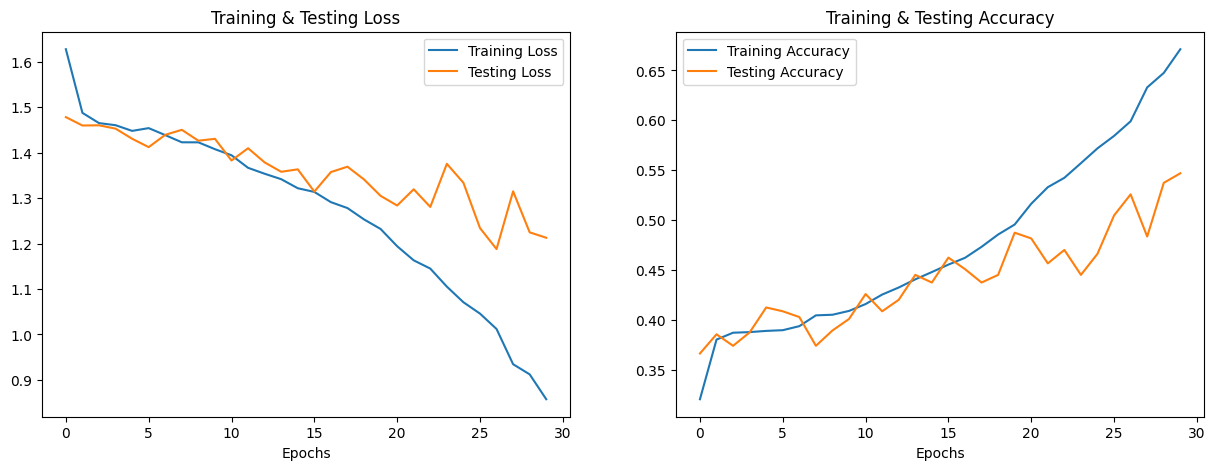

70/70 [==============================] - 1s 6ms/step


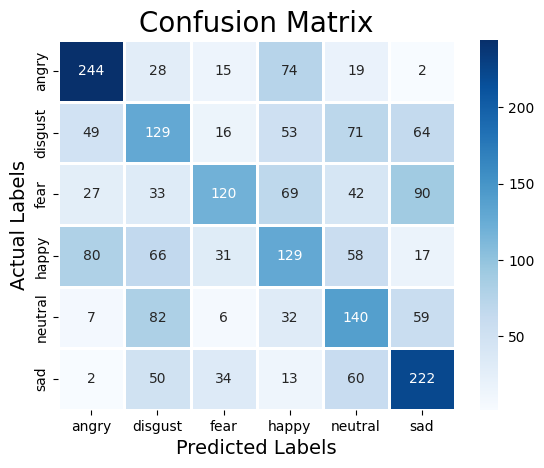

              precision    recall  f1-score   support

       angry       0.60      0.64      0.62       382
     disgust       0.33      0.34      0.34       382
        fear       0.54      0.31      0.40       381
       happy       0.35      0.34      0.34       381
     neutral       0.36      0.43      0.39       326
         sad       0.49      0.58      0.53       381

    accuracy                           0.44      2233
   macro avg       0.44      0.44      0.44      2233
weighted avg       0.45      0.44      0.44      2233



In [ ]:
get_plots(vgg16_model['history'], epochs=epochs_30)
get_stats(vgg16_model['model'], data_test_s1, labels_test_enc)

In [ ]:
# saving model
vgg16_model['model'].save(save_path+"vgg16_model.h5")

In [ ]:
lenet5_model = leNet5(data_train_s1, labels_train_s1, data_test_s1, labels_test_enc, data_val_s1, labels_val_s1, epochs=epochs_30)

Epoch 1/30
310/310 [==============================] - 12s 9ms/step - loss: 1.6546 - accuracy: 0.3386 - val_loss: 1.5358 - val_accuracy: 0.3378
Epoch 2/30
310/310 [==============================] - 3s 8ms/step - loss: 1.4498 - accuracy: 0.3931 - val_loss: 1.4515 - val_accuracy: 0.4012
Epoch 3/30
310/310 [==============================] - 3s 11ms/step - loss: 1.4024 - accuracy: 0.4202 - val_loss: 1.4083 - val_accuracy: 0.4338
Epoch 4/30
310/310 [==============================] - 3s 10ms/step - loss: 1.3662 - accuracy: 0.4352 - val_loss: 1.3870 - val_accuracy: 0.4261
Epoch 5/30
310/310 [==============================] - 2s 5ms/step - loss: 1.3362 - accuracy: 0.4487 - val_loss: 1.3723 - val_accuracy: 0.4376
Epoch 6/30
310/310 [==============================] - 2s 5ms/step - loss: 1.3254 - accuracy: 0.4559 - val_loss: 1.3347 - val_accuracy: 0.4568
Epoch 7/30
310/310 [==============================] - 2s 5ms/step - loss: 1.3061 - accuracy: 0.4677 - val_loss: 1.3849 - val_accuracy: 0.4338
Epo

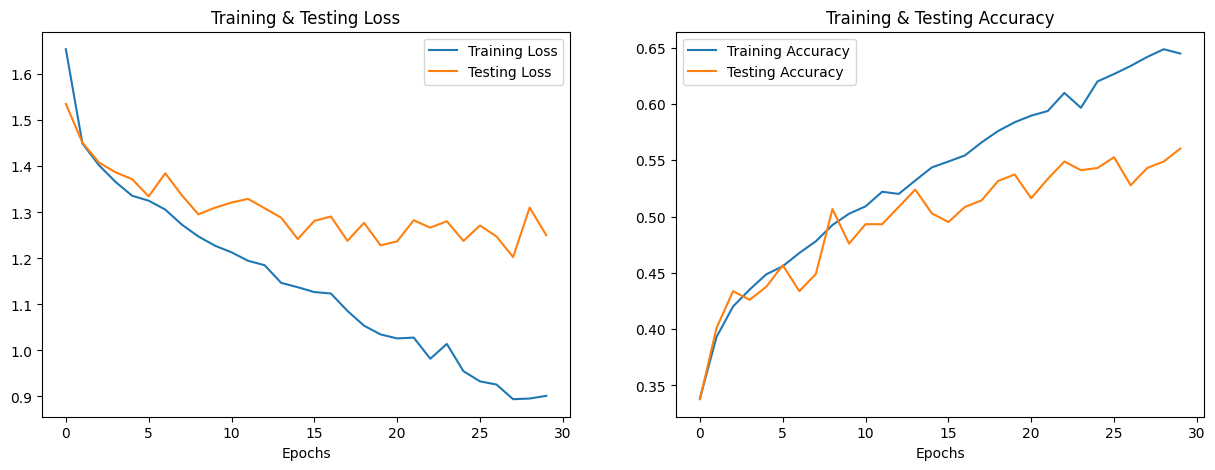

70/70 [==============================] - 0s 3ms/step


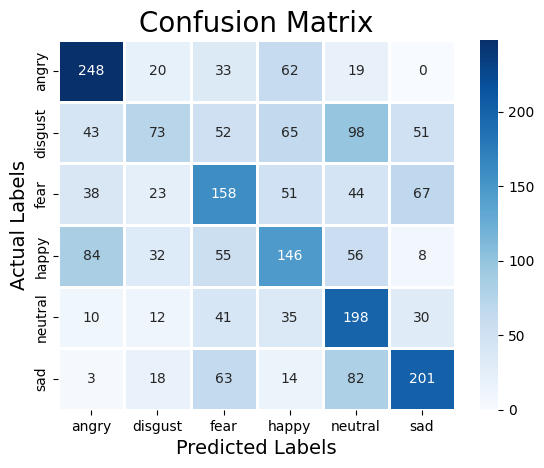

              precision    recall  f1-score   support

       angry       0.58      0.65      0.61       382
     disgust       0.41      0.19      0.26       382
        fear       0.39      0.41      0.40       381
       happy       0.39      0.38      0.39       381
     neutral       0.40      0.61      0.48       326
         sad       0.56      0.53      0.54       381

    accuracy                           0.46      2233
   macro avg       0.46      0.46      0.45      2233
weighted avg       0.46      0.46      0.45      2233



In [ ]:
get_plots(lenet5_model['history'], epochs=epochs_30)
get_stats(lenet5_model['model'], data_test_s1, labels_test_enc)

In [ ]:
lenet5_model['model'].save(save_path+"lenet5_model.h5")

In [ ]:
my_model = cnn_model(data_train_s1, labels_train_s1, data_test_s1, labels_test_enc, data_val_s1, labels_val_s1,  epochs=epochs_30)

Epoch 1/30
310/310 [==============================] - 6s 10ms/step - loss: 1.8392 - accuracy: 0.1809 - val_loss: 1.7443 - val_accuracy: 0.2169
Epoch 2/30
310/310 [==============================] - 2s 7ms/step - loss: 1.7309 - accuracy: 0.2423 - val_loss: 1.6671 - val_accuracy: 0.2975
Epoch 3/30
310/310 [==============================] - 2s 7ms/step - loss: 1.6530 - accuracy: 0.3069 - val_loss: 1.6534 - val_accuracy: 0.3359
Epoch 4/30
310/310 [==============================] - 2s 7ms/step - loss: 1.6378 - accuracy: 0.3080 - val_loss: 1.6312 - val_accuracy: 0.3417
Epoch 5/30
310/310 [==============================] - 2s 7ms/step - loss: 1.6120 - accuracy: 0.3221 - val_loss: 1.5971 - val_accuracy: 0.3589
Epoch 6/30
310/310 [==============================] - 3s 9ms/step - loss: 1.5945 - accuracy: 0.3220 - val_loss: 1.5534 - val_accuracy: 0.3455
Epoch 7/30
310/310 [==============================] - 3s 8ms/step - loss: 1.5907 - accuracy: 0.3219 - val_loss: 1.5410 - val_accuracy: 0.3685
Epoch

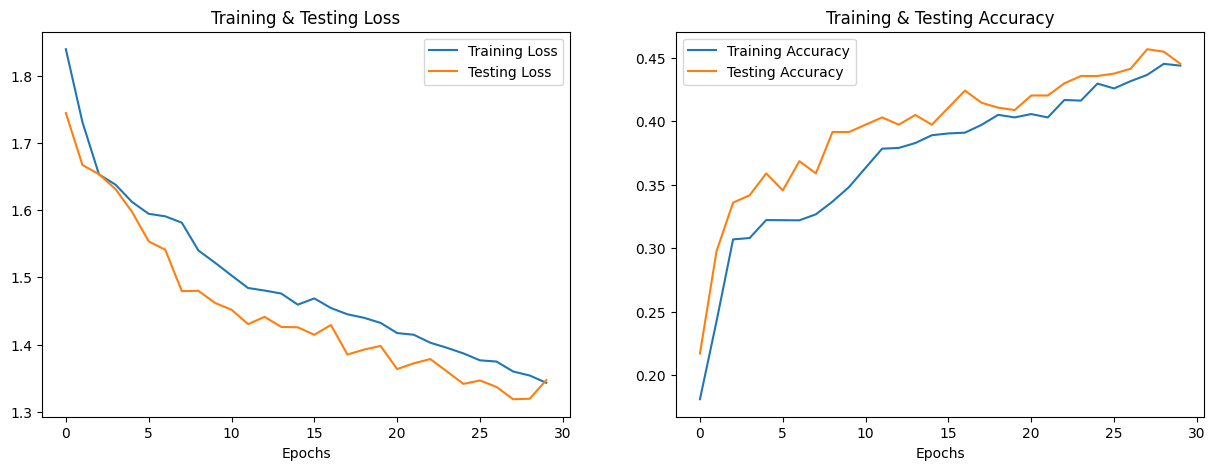

70/70 [==============================] - 0s 3ms/step


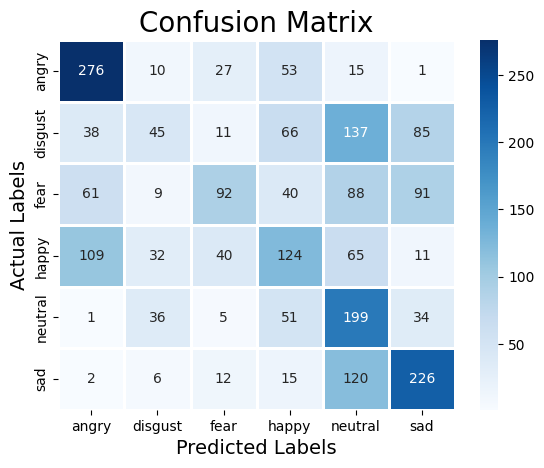

              precision    recall  f1-score   support

       angry       0.57      0.72      0.64       382
     disgust       0.33      0.12      0.17       382
        fear       0.49      0.24      0.32       381
       happy       0.36      0.33      0.34       381
     neutral       0.32      0.61      0.42       326
         sad       0.50      0.59      0.55       381

    accuracy                           0.43      2233
   macro avg       0.43      0.44      0.41      2233
weighted avg       0.43      0.43      0.41      2233



In [ ]:
get_plots(my_model['history'], epochs=epochs_30)
get_stats(my_model['model'], data_test_s1, labels_test_enc)

In [ ]:
my_model['model'].save(save_path+"my_model.h5")

VGG16 model: 0.44066277146339417
LeNet model: 0.45857590436935425
My model   : 0.4308105707168579


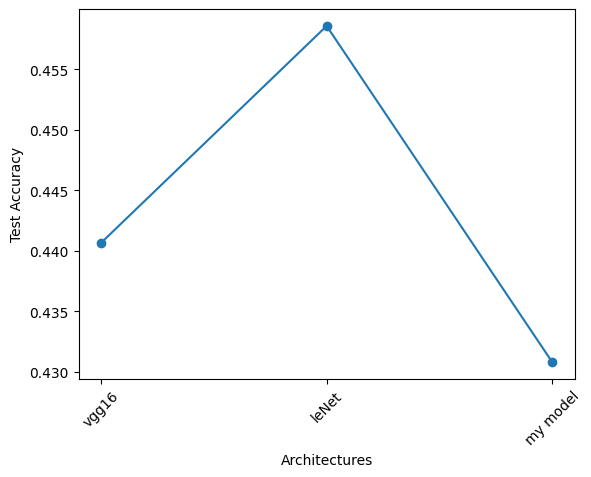

In [ ]:
print("VGG16 model:",vgg16_model['test_accuracy'])
print("LeNet model:",lenet5_model['test_accuracy'])
print("My model   :",my_model['test_accuracy'])

names = ['vgg16', 'leNet', 'my model']
test_acc = [vgg16_model['test_accuracy'], lenet5_model['test_accuracy'], my_model['test_accuracy']]

plt.plot(names, test_acc, linestyle='-', marker='o')
plt.xlabel('Architectures')
plt.ylabel('Test Accuracy')
plt.title('1D CONV')
plt.xticks(rotation=45)

plt.show()

In [ ]:
del vgg16_model
del lenet5_model
del my_model
gc.collect()

26870

### 2D-CNN:

#### CNN Architectures:

 ##### AlexNet architecture with 2D convolutional layers

In [ ]:
def alex_net_2d(train_data, train_labels, test_data, test_labels, val_data, val_labels, epochs=100, learning_rate=0.001):

    # Define the CNN model
    alexnet_model = tf.keras.Sequential()

    # Convolutional layers
    alexnet_model.add(layers.Conv2D(96, kernel_size=11, strides=4, activation='relu', input_shape=(train_data.shape[1], train_data.shape[2], 1)))
    alexnet_model.add(layers.MaxPooling2D(pool_size=3, strides=2))
    alexnet_model.add(layers.Conv2D(256, kernel_size=5, activation='relu'))
    alexnet_model.add(layers.MaxPooling2D(pool_size=3, strides=2))
    alexnet_model.add(layers.Conv2D(384, kernel_size=3, activation='relu'))
    alexnet_model.add(layers.Conv2D(384, kernel_size=3, activation='relu'))
    alexnet_model.add(layers.Conv2D(256, kernel_size=3, activation='relu'))
    alexnet_model.add(layers.MaxPooling2D(pool_size=3, padding='same', strides=2))

    # Flatten the features
    alexnet_model.add(layers.Flatten())

    # Dense layers
    alexnet_model.add(layers.Dense(4096, activation='relu'))
    alexnet_model.add(layers.Dense(4096, activation='relu'))
    alexnet_model.add(layers.Dense(train_labels.shape[1], activation='softmax'))

    # Compile the model
    alexnet_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                          loss='categorical_crossentropy', metrics=['accuracy'])
    alexnet_model.summary()
    # Train the model
    history = alexnet_model.fit(train_data, train_labels, epochs=epochs, validation_data=(val_data, val_labels))

    # Evaluate the model
    test_loss, test_accuracy = alexnet_model.evaluate(test_data, test_labels)
    print("Test Loss:", test_loss)
    print("Test Accuracy:", test_accuracy)

    return {
      "model":alexnet_model
      ,"history":history
      ,"test_accuracy":test_accuracy
      ,"test_loss":test_loss
     }


##### VGG-16:

In [ ]:
def vgg16_2d(train_data, train_labels, test_data, test_labels, val_data, val_labels, epochs=100, learning_rate=0.001):

    # Define the VGG16-based CNN model
    vgg16_model = tf.keras.Sequential()

    # Block 1
    vgg16_model.add(layers.Conv2D(64, kernel_size=3, activation='relu', padding='same', input_shape=(train_data.shape[1], train_data.shape[2], 1)))
    vgg16_model.add(layers.Conv2D(64, kernel_size=3, activation='relu', padding='same'))
    vgg16_model.add(layers.MaxPooling2D(pool_size=2, strides=2))

    # Block 2
    vgg16_model.add(layers.Conv2D(128, kernel_size=3, activation='relu', padding='same'))
    vgg16_model.add(layers.Conv2D(128, kernel_size=3, activation='relu', padding='same'))
    vgg16_model.add(layers.MaxPooling2D(pool_size=2, strides=2))

    # Block 3
    vgg16_model.add(layers.Conv2D(256, kernel_size=3, activation='relu', padding='same'))
    vgg16_model.add(layers.Conv2D(256, kernel_size=3, activation='relu', padding='same'))
    vgg16_model.add(layers.Conv2D(256, kernel_size=3, activation='relu', padding='same'))
    vgg16_model.add(layers.MaxPooling2D(pool_size=2, strides=2))

    # Block 4
    vgg16_model.add(layers.Conv2D(512, kernel_size=3, activation='relu', padding='same'))
    vgg16_model.add(layers.Conv2D(512, kernel_size=3, activation='relu', padding='same'))
    vgg16_model.add(layers.Conv2D(512, kernel_size=3, activation='relu', padding='same'))
    vgg16_model.add(layers.MaxPooling2D(pool_size=2, strides=2))

    # Block 5
    vgg16_model.add(layers.Conv2D(512, kernel_size=3, activation='relu', padding='same'))
    vgg16_model.add(layers.Conv2D(512, kernel_size=3, activation='relu', padding='same'))
    vgg16_model.add(layers.Conv2D(512, kernel_size=3, activation='relu', padding='same'))
    vgg16_model.add(layers.MaxPooling2D(pool_size=2, strides=2))

    # Flatten the feature maps
    vgg16_model.add(layers.Flatten())

    # Dense layers
    vgg16_model.add(layers.Dense(4096, activation='relu'))
    vgg16_model.add(layers.Dense(4096, activation='relu'))
    vgg16_model.add(layers.Dense(train_labels.shape[1], activation='softmax'))  # num_classes is the number of classes

    # Compile the model
    vgg16_model.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])
    
    
    # Train the model
    history = vgg16_model.fit(train_data, train_labels, epochs=epochs, validation_data=(val_data, val_labels))

    # Evaluate the model
    test_loss, test_accuracy = vgg16_model.evaluate(test_data, test_labels)
    print("Test Loss:", test_loss)
    print("Test Accuracy:", test_accuracy)

    return {
      "model":vgg16_model
      ,"history":history
      ,"test_accuracy":test_accuracy
      ,"test_loss":test_loss
     }

##### LeNet-5:


In [ ]:
def leNet5_2d(train_data, train_labels, test_data, test_labels, val_data, val_labels, epochs=100, learning_rate=0.001):

    # Define the LeNet-5 CNN model
    lenet5_model = tf.keras.Sequential()

    # Layer 1: Convolutional layer
    lenet5_model.add(layers.Conv2D(6, kernel_size=5, activation='relu', input_shape=(train_data.shape[1], train_data.shape[2], 1)))
    lenet5_model.add(layers.MaxPooling2D(pool_size=2, strides=2))

    # Layer 2 Convolutional layer
    lenet5_model.add(layers.Conv2D(16, kernel_size=5, activation='relu'))
    lenet5_model.add(layers.MaxPooling2D(pool_size=2, strides=2))

    # Flatten the feature maps
    lenet5_model.add(layers.Flatten())

    # Dense layers
    
    # Layer 3 Fully connected layer
    lenet5_model.add(layers.Dense(120, activation='relu'))

    # Layer 4 Fully connected layer
    lenet5_model.add(layers.Dense(84, activation='relu'))

    # Output layer
    lenet5_model.add(layers.Dense(train_labels.shape[1], activation='softmax'))

    # Compile the model
    lenet5_model.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])
    
    
    # Train the model
    history = lenet5_model.fit(train_data, train_labels, epochs=epochs, validation_data=(val_data, val_labels))

    # Evaluate the model
    test_loss, test_accuracy = lenet5_model.evaluate(test_data, test_labels)
    print("Test Loss:", test_loss)
    print("Test Accuracy:", test_accuracy)


    return {
      "model":lenet5_model
      ,"history":history
      ,"test_accuracy":test_accuracy
      ,"test_loss":test_loss
     }

##### My-model:

In [ ]:
def cnn_model_2d(train_data, train_labels, test_data, test_labels, val_data, val_labels, epochs=100, learning_rate=0.001):
    
     # Define the CNN model
    model=tf.keras.Sequential()

    # Layer 1: Convolutional layer
    model.add(layers.Conv2D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(train_data.shape[1], train_data.shape[2], 1)))
    model.add(layers.MaxPooling2D(pool_size=5, strides = 2, padding = 'same'))

    # Layer 2: Convolutional layer
    model.add(layers.Conv2D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=5, strides = 2, padding = 'same'))

    # Layer 3: Convolutional layer
    model.add(layers.Conv2D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=5, strides = 2, padding = 'same'))
    model.add(layers.Dropout(0.2))

    # Layer 4: Convolutional layer
    model.add(layers.Conv2D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=5, strides = 2, padding = 'same'))

    model.add(layers.Flatten())

    # Dense layers
    
    # Layer 5 Fully connected layer
    model.add(layers.Dense(units=32, activation='relu'))
    model.add(layers.Dropout(0.3))

    # Output layer
    model.add(layers.Dense(units=6, activation='softmax'))
    
    # Compile the model
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])
    
    
    # Train the model
    history = model.fit(train_data, train_labels, epochs=epochs, validation_data=(val_data, val_labels))

    # Evaluate the model
    test_loss, test_accuracy = model.evaluate(test_data, test_labels)
    print("Test Loss:", test_loss)
    print("Test Accuracy:", test_accuracy)

    return {
      "model":model
      ,"history":history
      ,"test_accuracy":test_accuracy
      ,"test_loss":test_loss
     }

#### Models Results:

In [ ]:
alexnet_model_2d = alex_net_2d(data_train_s2, labels_train_s2, data_test_s2, labels_test_enc, data_val_s2, labels_val_s2, epochs=epochs_30)

In [ ]:
get_plots(alexnet_model_2d['history'], epochs=epochs_30)
get_stats(alexnet_model_2d['model'], data_test_s1, labels_test_enc)

In [ ]:
# saving the model
alexnet_model_2d['model'].save(save_path+"alexnet_model_2d.h5")

In [ ]:
vgg16_model_2d = vgg16_2d(data_train_s2, labels_train_s2, data_test_s2, labels_test_enc, data_val_s2, labels_val_s2, epochs=epochs_30)

Epoch 1/20
310/310 [==============================] - 81s 241ms/step - loss: 3.1820 - accuracy: 0.3556 - val_loss: 1.4535 - val_accuracy: 0.3896
Epoch 2/20
310/310 [==============================] - 72s 232ms/step - loss: 1.4421 - accuracy: 0.4097 - val_loss: 1.4209 - val_accuracy: 0.4088
Epoch 3/20
310/310 [==============================] - 71s 230ms/step - loss: 1.4212 - accuracy: 0.4250 - val_loss: 1.3770 - val_accuracy: 0.4242
Epoch 4/20
310/310 [==============================] - 71s 228ms/step - loss: 1.3785 - accuracy: 0.4345 - val_loss: 1.3497 - val_accuracy: 0.3954
Epoch 5/20
310/310 [==============================] - 71s 230ms/step - loss: 1.3323 - accuracy: 0.4528 - val_loss: 1.3673 - val_accuracy: 0.4357
Epoch 6/20
310/310 [==============================] - 71s 229ms/step - loss: 1.2983 - accuracy: 0.4746 - val_loss: 1.2958 - val_accuracy: 0.4511
Epoch 7/20
310/310 [==============================] - 71s 229ms/step - loss: 1.2385 - accuracy: 0.4989 - val_loss: 1.1931 - val_ac

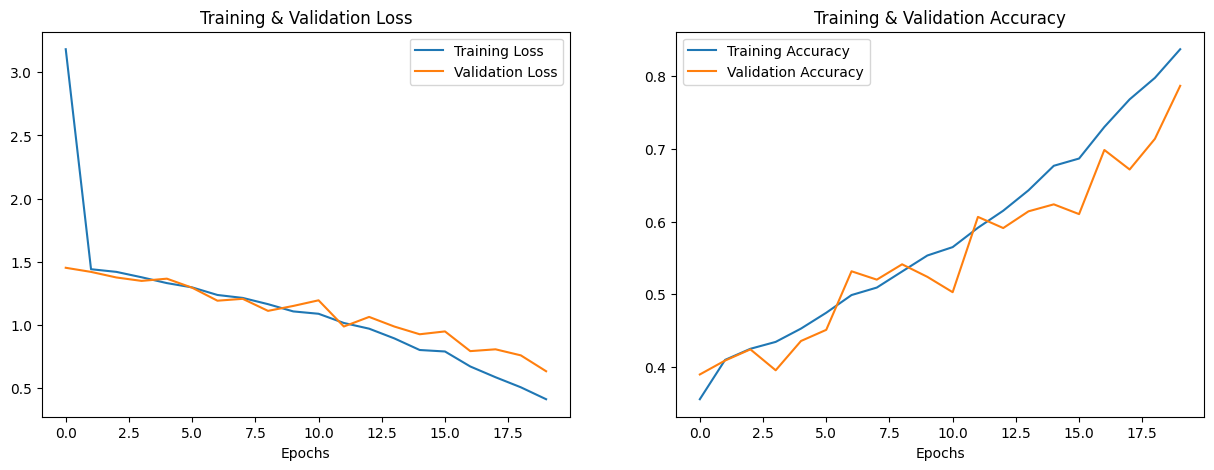

70/70 [==============================] - 5s 63ms/step


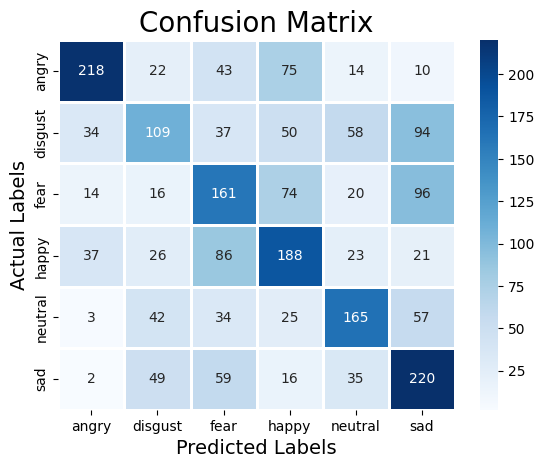

              precision    recall  f1-score   support

       angry       0.71      0.57      0.63       382
     disgust       0.41      0.29      0.34       382
        fear       0.38      0.42      0.40       381
       happy       0.44      0.49      0.46       381
     neutral       0.52      0.51      0.51       326
         sad       0.44      0.58      0.50       381

    accuracy                           0.48      2233
   macro avg       0.48      0.48      0.48      2233
weighted avg       0.48      0.48      0.47      2233



In [ ]:
get_plots(vgg16_model_2d['history'], epochs=epochs_30)
get_stats(vgg16_model_2d['model'], data_test_s2, labels_test_enc)

In [ ]:
# saving the model
vgg16_model_2d['model'].save(save_path+"vgg16_model_2d.h5")

In [ ]:
lenet5_model_2d = leNet5_2d(data_train_s2, labels_train_s2, data_test_s2, labels_test_enc, data_val_s2, labels_val_s2, epochs=epochs_30)

Epoch 1/20
310/310 [==============================] - 8s 11ms/step - loss: 1.8540 - accuracy: 0.3531 - val_loss: 1.3871 - val_accuracy: 0.4395
Epoch 2/20
310/310 [==============================] - 3s 10ms/step - loss: 1.3075 - accuracy: 0.4809 - val_loss: 1.2174 - val_accuracy: 0.4933
Epoch 3/20
310/310 [==============================] - 3s 10ms/step - loss: 1.1718 - accuracy: 0.5576 - val_loss: 1.3956 - val_accuracy: 0.4702
Epoch 4/20
310/310 [==============================] - 3s 9ms/step - loss: 1.0363 - accuracy: 0.6172 - val_loss: 1.0761 - val_accuracy: 0.6065
Epoch 5/20
310/310 [==============================] - 3s 9ms/step - loss: 0.8997 - accuracy: 0.6850 - val_loss: 1.0387 - val_accuracy: 0.6449
Epoch 6/20
310/310 [==============================] - 3s 9ms/step - loss: 0.7035 - accuracy: 0.7577 - val_loss: 0.8189 - val_accuracy: 0.7044
Epoch 7/20
310/310 [==============================] - 3s 10ms/step - loss: 0.5253 - accuracy: 0.8195 - val_loss: 0.6209 - val_accuracy: 0.7754
Ep

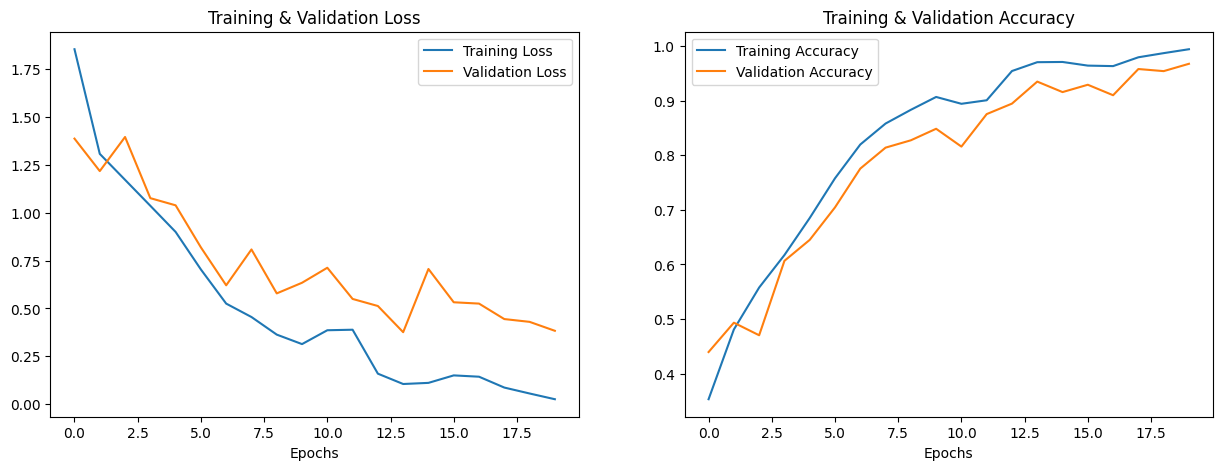

70/70 [==============================] - 1s 6ms/step


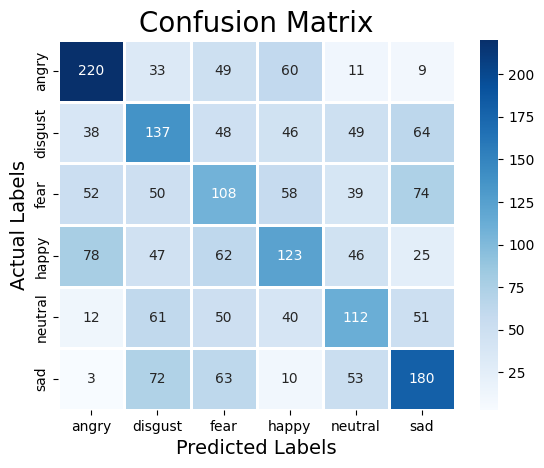

              precision    recall  f1-score   support

       angry       0.55      0.58      0.56       382
     disgust       0.34      0.36      0.35       382
        fear       0.28      0.28      0.28       381
       happy       0.36      0.32      0.34       381
     neutral       0.36      0.34      0.35       326
         sad       0.45      0.47      0.46       381

    accuracy                           0.39      2233
   macro avg       0.39      0.39      0.39      2233
weighted avg       0.39      0.39      0.39      2233



In [ ]:
get_plots(lenet5_model_2d['history'], epochs=epochs_30)
get_stats(lenet5_model_2d['model'], data_test_s2, labels_test_enc)

In [ ]:
# saving the model
lenet5_model_2d['model'].save(save_path+"lenet5_model_2d.h5")

In [ ]:
my_model_2d = cnn_model_2d(data_train_s2, labels_train_s2, data_test_s2, labels_test_enc, data_val_s2, labels_val_s2, epochs=epochs_30)

Epoch 1/20
310/310 [==============================] - 86s 233ms/step - loss: 2.3128 - accuracy: 0.2041 - val_loss: 1.7423 - val_accuracy: 0.2438
Epoch 2/20
310/310 [==============================] - 68s 218ms/step - loss: 1.7620 - accuracy: 0.2185 - val_loss: 1.7344 - val_accuracy: 0.2649
Epoch 3/20
310/310 [==============================] - 67s 218ms/step - loss: 1.7445 - accuracy: 0.2310 - val_loss: 1.7955 - val_accuracy: 0.1727
Epoch 4/20
310/310 [==============================] - 67s 218ms/step - loss: 1.7570 - accuracy: 0.2117 - val_loss: 1.6887 - val_accuracy: 0.2917
Epoch 5/20
310/310 [==============================] - 68s 219ms/step - loss: 1.7025 - accuracy: 0.2529 - val_loss: 1.6567 - val_accuracy: 0.2994
Epoch 6/20
310/310 [==============================] - 67s 218ms/step - loss: 1.6888 - accuracy: 0.2516 - val_loss: 1.6650 - val_accuracy: 0.2821
Epoch 7/20
310/310 [==============================] - 67s 218ms/step - loss: 1.6915 - accuracy: 0.2525 - val_loss: 1.6170 - val_ac

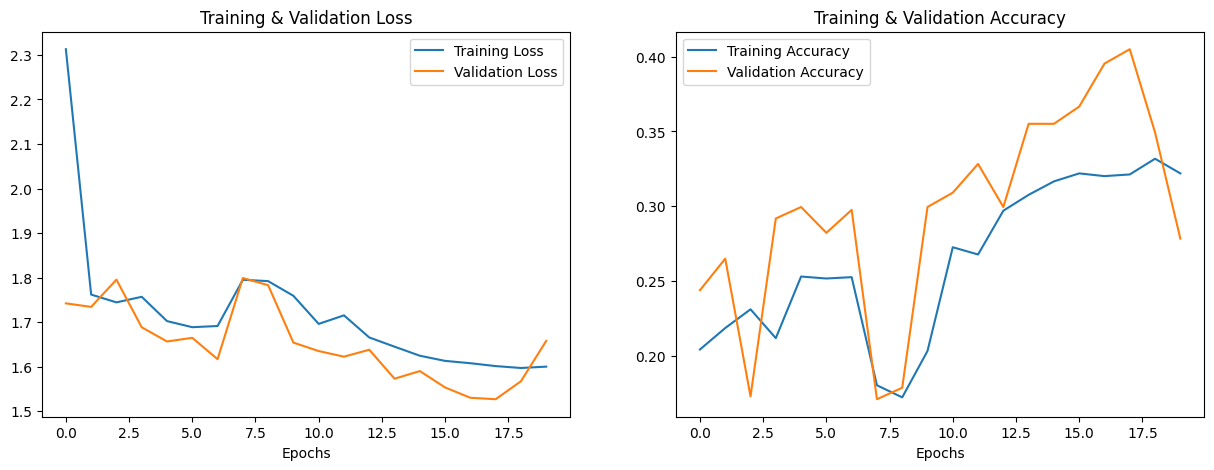

70/70 [==============================] - 4s 54ms/step


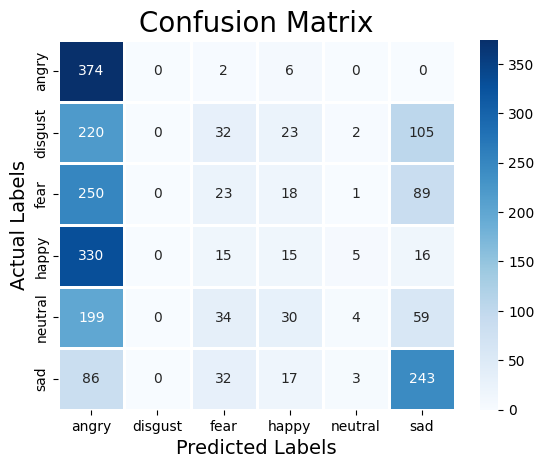

              precision    recall  f1-score   support

       angry       0.26      0.98      0.41       382
     disgust       0.00      0.00      0.00       382
        fear       0.17      0.06      0.09       381
       happy       0.14      0.04      0.06       381
     neutral       0.27      0.01      0.02       326
         sad       0.47      0.64      0.54       381

    accuracy                           0.30      2233
   macro avg       0.22      0.29      0.19      2233
weighted avg       0.22      0.30      0.19      2233



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
get_plots(my_model_2d['history'], epochs=epochs_30)
get_stats(my_model_2d['model'], data_test_s2, labels_test_enc)

In [ ]:
# saving the model
my_model_2d['model'].save(save_path+"my_model_2d.h5")

VGG16 model: 0.475145548582077
LeNet model: 0.39408865571022034
My model   : 0.29511865973472595


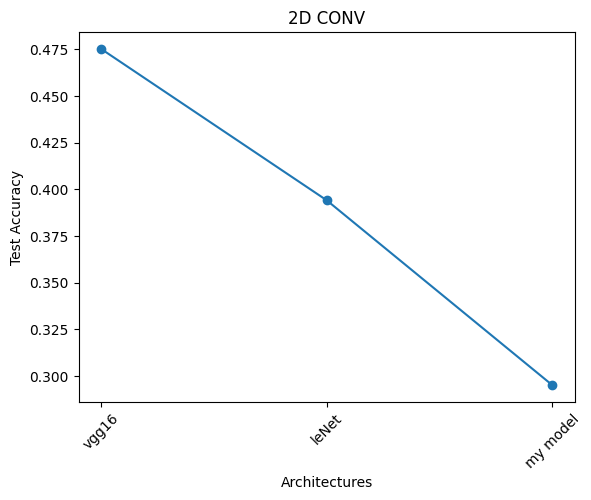

In [ ]:
print("VGG16 model:",vgg16_model_2d['test_accuracy'])
print("LeNet model:",lenet5_model_2d['test_accuracy'])
print("My model   :",my_model_2d['test_accuracy'])

names = ['vgg16', 'leNet', 'my model']
test_acc = [vgg16_model_2d['test_accuracy'], lenet5_model_2d['test_accuracy'], my_model_2d['test_accuracy']]


plt.plot(names, test_acc, linestyle='-', marker='o')

plt.xlabel('Architectures')
plt.ylabel('Test Accuracy')
plt.title('2D CONV')
plt.xticks(rotation=45)


plt.show()

### Some architectures in this assignment were inspired by those papers: